# Semantic Segmentation
## Project GOAL : Detect Road from KITTI dataset
- Data Download link : http://www.cvlibs.net/datasets/kitti/eval_semantics.php  

# Set up and Check Environment

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!nvidia-smi

Fri Nov 17 06:24:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    12W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Data
## 1.1 Data Loader

In [3]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

# Train Dataset -> return Randomly HorizontalFlip or Crop & Resized image
# Test Dataset -> return Resized image
def build_augmentation(is_train=True):
    if is_train:
        return Compose([
            HorizontalFlip(p=0.5),   
                    RandomSizedCrop(        
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              
                        width=224,
                        height=224
                        )
                    ])
    return Compose([ 
                Resize(
                    width=224,
                    height=224
                    )
                ])

In [4]:
def DL_build_augmentation(is_train=True):
    if is_train:
        return Compose([
            HorizontalFlip(p=0.5),   
                    RandomSizedCrop(        
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              
                        width=448,
                        height=448
                        )
                    ])
    return Compose([ 
                Resize(
                    width=448,
                    height=448
                    )
                ])

In [5]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))


DLaugmentation_train = DL_build_augmentation()
DLaugmentation_test = DL_build_augmentation(is_train=False)

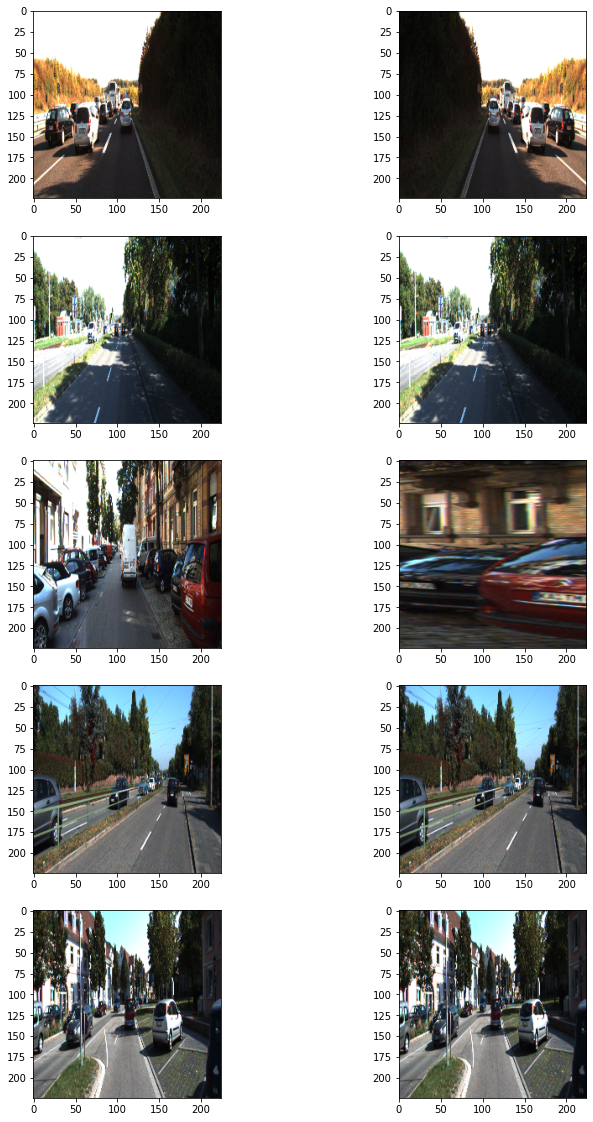

In [8]:
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"]) 
plt.show()

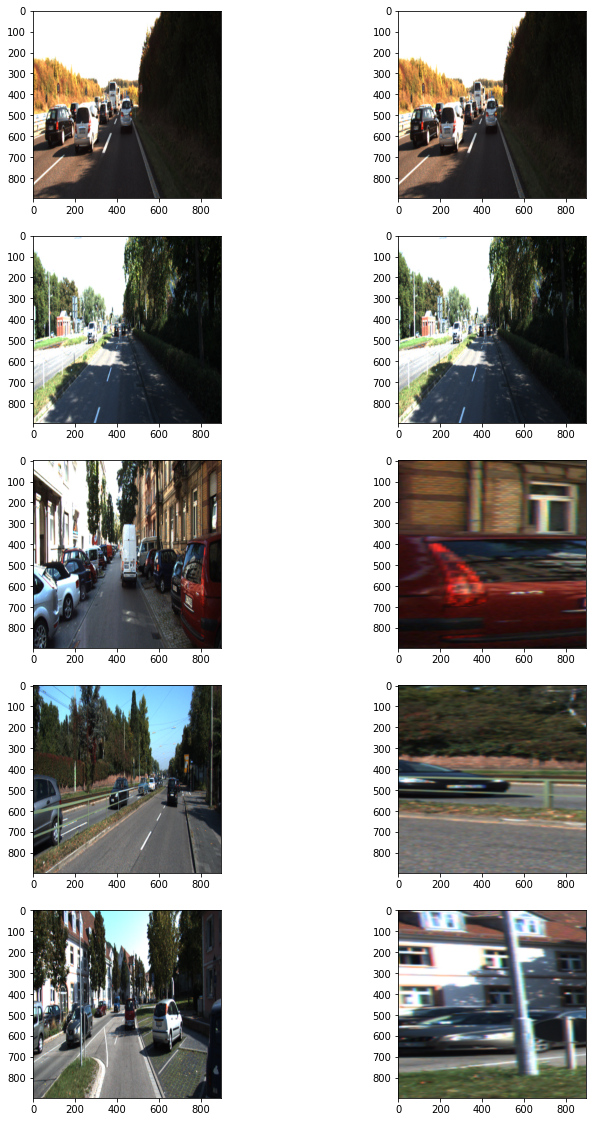

In [9]:
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image":image}
    resized = DLaugmentation_test(**image_data)
    processed = DLaugmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"]) 
plt.show()

In [6]:
class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self, 
               dir_path,
               batch_size=8,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        self.data = self.load_dataset()
        
    # Load Dataset 
    # Number of Validation dataset or Test dataset = 30
    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        
        input_images.sort()
        label_images.sort()
        
        assert len(input_images) == len(label_images)
        
        data = [_ for _ in zip (input_images, label_images)]
        
        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    # Retrieve Data length
    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)
    
    
    # Retrieve one batch augmented item set
    def __getitem__(self, index):
        batch_data = self.data[
            index*self.batch_size:
            (index + 1)*self.batch_size
        ]
        
        # setup dimensions
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
              "image": _input,
              "mask": _output,
            }
            augmented = self.augmentation(**data)
            
            # Convert input image pixels value to 0~1
            # Because augmented["mask"] value consists of 0 value or 1 value
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs
    
    # Randomly shuffle the dataset
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        return self.indexes

In [7]:
class DL_KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self, 
               dir_path,
               batch_size=8,
               img_size=(448, 448, 3),
               output_size=(448, 448),
               is_train=True,
               augmentation=None):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        self.data = self.load_dataset()
        
    # Load Dataset 
    # Number of Validation dataset or Test dataset = 30
    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        
        input_images.sort()
        label_images.sort()
        
        assert len(input_images) == len(label_images)
        
        data = [_ for _ in zip (input_images, label_images)]
        
        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    # Retrieve Data length
    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)
    
    
    # Retrieve one batch augmented item set
    def __getitem__(self, index):
        batch_data = self.data[
            index*self.batch_size:
            (index + 1)*self.batch_size
        ]
        
        # setup dimensions
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
              "image": _input,
              "mask": _output,
            }
            augmented = self.augmentation(**data)
            
            # Convert input image pixels value to 0~1
            # Because augmented["mask"] value consists of 0 value or 1 value
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs
    
    # Randomly shuffle the dataset
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        return self.indexes

In [8]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [9]:
DLaugmentation = DL_build_augmentation()
DLtest_preproc = DL_build_augmentation(is_train=False)
        
DL_train_generator = DL_KittiGenerator(
    dir_path, 
    augmentation=DLaugmentation,
)

DL_test_generator = DL_KittiGenerator(
    dir_path, 
    augmentation=DLtest_preproc,
    is_train=False
)

# 2. Model
## 2.1 Build Model
- own_model : UNet  
- Nested_UNet: UNet ++  

## UNet

In [10]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, BatchNormalization, Concatenate, SeparableConv2D, UpSampling2D
from tensorflow.keras.layers import Input, Conv2D

In [18]:
def conv_block_for_UNet(inputs, filter_size):
    x = Conv2D(filter_size, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filter_size, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [19]:
def build_UNet_model(input_shape=(224, 224, 3)):
    min_filter_size = 64
    max_filter_size = 512
    
    encode_blocks = []
    
    
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    
    # Encoder
    for i in range(4):
        filter_size = min_filter_size * (2**i)
        x = conv_block_for_UNet(x, filter_size)
        encode_blocks.append(x)
        x = MaxPooling2D((2,2))(x)

    # Middle
    x = conv_block_for_UNet(x, 1024)
    
    # Decoder
    for i in range(4):
        filter_size = max_filter_size * (2**(-i))
        x = Conv2DTranspose(filter_size, (2,2), strides=2, padding='same')(x)
        x = Concatenate()([x, encode_blocks[3-i]])
        x = conv_block_for_UNet(x , filter_size)
    
    x = Conv2D(2, 3, padding='same')(x)
    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
own_model = build_UNet_model()
own_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## UNet++

In [20]:
def create_nest_block(nest_blocks, index):
    layers = [64, 128, 256, 512]
    nest_block = []

    last_index = len(nest_blocks[index]) - 1
    for i in range(0, last_index):
        up = Conv2DTranspose(layers[i], (2, 2), strides=2, padding='same')(nest_blocks[index][i + 1])
        print(f"{index}-th upshape: {up.shape}")
        
        concat = up  # Initialize concat with the up tensor
        for j in range(index + 1):
            concat = Concatenate()([concat, nest_blocks[j][i]])
        concat = conv_block_for_UNet(concat, up.shape[-1])
        nest_block.append(concat)
        
        print(f"{index}-th concat: {concat.shape}")
    nest_blocks.append(nest_block)


In [21]:
def build_Nested_UNet_model(input_shape=(224, 224, 3)):
    min_filter_size = 64
    max_filter_size = 512
    
    encode_blocks = []
    
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    
    # Encoder
    for i in range(5):
        filter_size = min_filter_size * (2**i)
        x = conv_block_for_UNet(x, filter_size)
        if i != 4:
            encode_blocks.append(x)
            x = MaxPooling2D((2,2))(x)
        else:
            encode_blocks.append(x)
        
            
    nest_blocks = []
    nest_blocks.append(encode_blocks)
    
    # Nest Calculate
    for i in range(4):
        create_nest_block(nest_blocks, i)
    
    print(nest_blocks[4])
    x = Conv2D(2, 3, padding='same')(nest_blocks[4][0])
    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [22]:
Nested_UNet = build_Nested_UNet_model()
Nested_UNet.summary()

0-th upshape: (None, 224, 224, 64)
0-th concat: (None, 224, 224, 64)
0-th upshape: (None, 112, 112, 128)
0-th concat: (None, 112, 112, 128)
0-th upshape: (None, 56, 56, 256)
0-th concat: (None, 56, 56, 256)
0-th upshape: (None, 28, 28, 512)
0-th concat: (None, 28, 28, 512)
1-th upshape: (None, 224, 224, 64)
1-th concat: (None, 224, 224, 64)
1-th upshape: (None, 112, 112, 128)
1-th concat: (None, 112, 112, 128)
1-th upshape: (None, 56, 56, 256)
1-th concat: (None, 56, 56, 256)
2-th upshape: (None, 224, 224, 64)
2-th concat: (None, 224, 224, 64)
2-th upshape: (None, 112, 112, 128)
2-th concat: (None, 112, 112, 128)
3-th upshape: (None, 224, 224, 64)
3-th concat: (None, 224, 224, 64)
[<KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'activation_29')>]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inpu

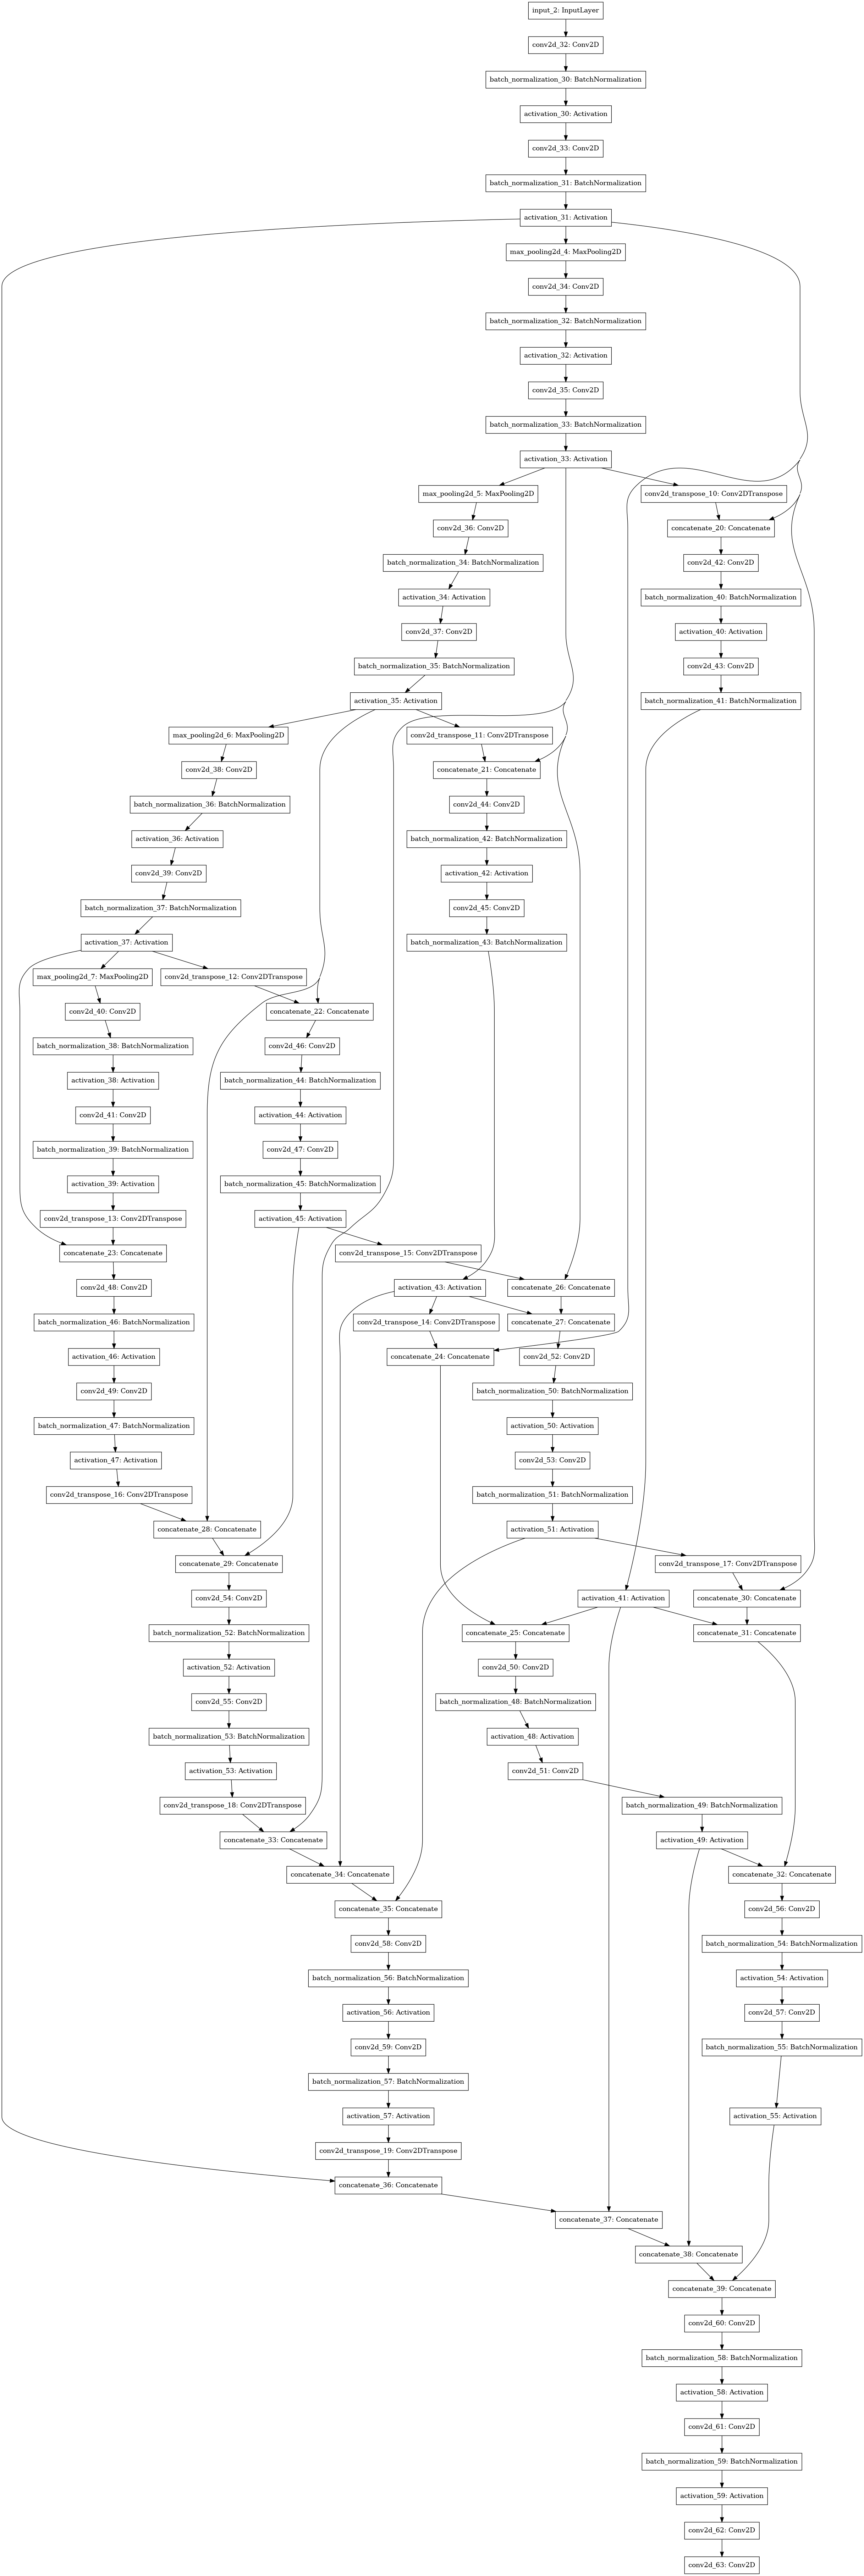

In [15]:
from tensorflow.keras.utils import plot_model


plot_model(Nested_UNet, to_file='./model_UNet++.png')

## DeepLab v3 +

In [16]:
def entry_flow_block(inputs):
    x = Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    layer_list = [128, 256, 728]
    
    for i in range(3):
        residual = x 
        residual = Conv2D(layer_list[i], 1, strides=2, padding='same')(residual)
        
        if i != 0:
            x = Activation('relu')(x)
        x = SeparableConv2D(layer_list[i], 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(layer_list[i], 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(3, 3), strides=2, padding="same")(x)
        x = Add()([x, residual])
    return x
    
def middle_flow_block(inputs):
    residual = inputs
    x = inputs
    
    for i in range(3):
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
    x = Add()([x, residual])
    
    return x
    
def exit_flow_block(inputs):
    residual = inputs
    x = inputs
    residual = Conv2D(1024, 1, strides=2, padding='same')(residual)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding="same")(x)
    x = Add()([x, residual])
    
    x = SeparableConv2D(1536, 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)
    
    x = SeparableConv2D(2048, 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)
    
    return x

In [17]:
def ASPP(inputs):
    
    conv_1 = SeparableConv2D(2048, 1)(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation('relu')(conv_1)
    
    conv_6 = SeparableConv2D(2048, 3, strides=1, padding='same', dilation_rate=6)(inputs)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation('relu')(conv_6)
    
    conv_12 = SeparableConv2D(2048, 3, strides=1, padding='same', dilation_rate=12)(inputs)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation('relu')(conv_12)
    
    conv_18 = SeparableConv2D(2048, 3, strides=1, padding='same', dilation_rate=18)(inputs)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation('relu')(conv_18)
    
    img_pooling = MaxPooling2D((2,2))(inputs)
    img_pooling = Conv2D(2048, 1, padding='same')(img_pooling)
    img_pooling = BatchNormalization()(img_pooling)
    img_pooling = Activation('relu')(img_pooling)
    img_pooling = UpSampling2D(size=(2, 2), interpolation='bilinear')(img_pooling)
    
    outputs = Concatenate()([conv_1, conv_6, conv_12, conv_18, img_pooling])
    outputs = Conv2D(512, 1, padding='same')(outputs)
    outputs = UpSampling2D(size=(4, 4), interpolation='bilinear')(outputs)
    return outputs

In [21]:
def build_DLV3Plus_model(input_shape=(448, 448, 3)):
    min_filter_size = 64
    max_filter_size = 512
    
    encode_blocks = []
    
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    
    # Encoder
    # Entry Flow
    x = entry_flow_block(inputs)
    # Middle Flow
    for i in range(8):
        x = middle_flow_block(x)
    # Exit Flow
    exit_1 = exit_flow_block(x) # 28, 28, 2048
    exit_2 = ASPP(exit_1) ## 112, 112, 512
    
    # Decoder
    exit_1 = Conv2D(512, 1, padding='same')(exit_1)
    print(exit_1.shape)
    exit_1 = UpSampling2D(size=(4, 4), interpolation='bilinear')(exit_1)
    outputs = Concatenate()([exit_1, exit_2])
    
    outputs = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(outputs)
    outputs = UpSampling2D(size=(4, 4), interpolation='bilinear')(outputs)
    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(outputs)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [22]:
DLV3_plus = build_DLV3Plus_model()
DLV3_plus.summary()

(None, 14, 14, 512)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 224, 224, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 224, 224, 32) 128         conv2d_10[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 224, 224, 32) 0           batch_normalization_41[0][0]     
________________________________________________________________________

## 2.2 Train Model 
## UNet

In [21]:
model_path = os.getenv('HOME')+'/aiffel/AIFEL_Quest/Going_Deeper/Project_05/seg_model_unet.h5'

own_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['Accuracy'])

history = own_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

own_model.save(model_path)

Epoch 1/100
11/11 [==============================] - 12s 981ms/step - loss: 0.1988 - Accuracy: 0.9255 - val_loss: 0.3654 - val_Accuracy: 0.8701
Epoch 2/100
11/11 [==============================] - 11s 933ms/step - loss: 0.1821 - Accuracy: 0.9323 - val_loss: 0.4284 - val_Accuracy: 0.8571
Epoch 3/100
11/11 [==============================] - 11s 941ms/step - loss: 0.1987 - Accuracy: 0.9206 - val_loss: 0.3021 - val_Accuracy: 0.8643
Epoch 4/100
11/11 [==============================] - 10s 917ms/step - loss: 0.1951 - Accuracy: 0.9254 - val_loss: 0.3882 - val_Accuracy: 0.8536
Epoch 5/100
11/11 [==============================] - 10s 902ms/step - loss: 0.2141 - Accuracy: 0.9272 - val_loss: 0.2739 - val_Accuracy: 0.8816
Epoch 6/100
11/11 [==============================] - 10s 895ms/step - loss: 0.1763 - Accuracy: 0.9353 - val_loss: 0.2872 - val_Accuracy: 0.8910
Epoch 7/100
11/11 [==============================] - 10s 895ms/step - loss: 0.1627 - Accuracy: 0.9438 - val_loss: 0.2808 - val_Accuracy:

In [22]:
import json

history_path = os.path.join(os.getenv('HOME'), 'aiffel/semantic_segmentation/history_unet.json')
with open(history_path, 'w') as json_file:
    json.dump(history.history, json_file)

<Figure size 432x288 with 0 Axes>

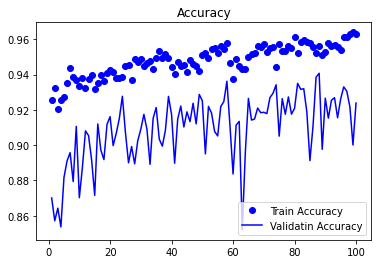

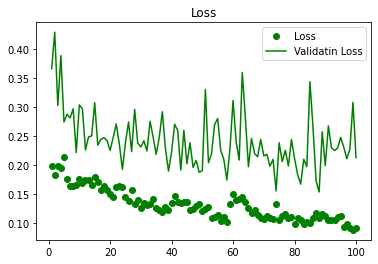

<Figure size 432x288 with 0 Axes>

In [23]:
accuracy = history.history["Accuracy"]
val_accuracy = history.history["val_Accuracy"]
loss = history.history["loss"]
val_loss =  history.history["val_loss"]
                 
epochs = range(1, 101)                           
                            
plt.plot(epochs, accuracy, "bo", label="Train Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validatin Accuracy")
plt.title("Accuracy")
plt.legend()
plt.figure()                            
                            
plt.plot(epochs, loss, "go", label="Loss")
plt.plot(epochs, val_loss, "g", label="Validatin Loss")
plt.title("Loss")
plt.legend()
plt.figure()  


In [11]:
own_model_path = os.getenv('HOME')+'/aiffel/AIFEL_Quest/Going_Deeper/Project_05/seg_model_unet.h5'

UNet = tf.keras.models.load_model(own_model_path)

## UNet++

In [13]:
import tensorflow as tf
from keras.layers import Flatten
from tensorflow.keras.losses import binary_crossentropy

def dice_coefficient(y_true, y_pred):
    smooth = 1e-15
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def combined_loss(y_true, y_pred):
    epsilon = 1e-15
    
    # Flatten the tensors
    y_true_flat = tf.keras.layers.Flatten()(y_true)
    y_pred_flat = tf.keras.layers.Flatten()(y_pred)
    
    # Binary Cross-Entropy
    bce = binary_crossentropy(y_true_flat, y_pred_flat)
    
    # Dice Coefficient
    dice = 1 - dice_coefficient(y_true_flat, y_pred_flat)
    
    # Combine the terms
    loss = 0.5 * bce + 0.5 * dice
    
    return tf.reduce_mean(loss)

In [33]:
Nested_UNet_model_path = os.getenv('HOME')+'/aiffel/AIFEL_Quest/Going_Deeper/Project_05/seg_model_unet++.h5'

Nested_UNet.compile(optimizer=Adam(1e-5),
                  loss=combined_loss,
                  metrics=['Accuracy'])


Nested_UNet_history = Nested_UNet.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

Nested_UNet.save(Nested_UNet_model_path)

Epoch 1/100
22/22 [==============================] - 30s 1s/step - loss: 2.1880 - Accuracy: 0.2153 - val_loss: 1.3805 - val_Accuracy: 0.4314
Epoch 2/100
22/22 [==============================] - 25s 1s/step - loss: 0.8653 - Accuracy: 0.5291 - val_loss: 2.1292 - val_Accuracy: 0.3774
Epoch 3/100
22/22 [==============================] - 25s 1s/step - loss: 0.4613 - Accuracy: 0.8145 - val_loss: 2.0971 - val_Accuracy: 0.3276
Epoch 4/100
22/22 [==============================] - 25s 1s/step - loss: 0.3773 - Accuracy: 0.8817 - val_loss: 1.9180 - val_Accuracy: 0.4506
Epoch 5/100
22/22 [==============================] - 25s 1s/step - loss: 0.3409 - Accuracy: 0.8987 - val_loss: 1.4472 - val_Accuracy: 0.5941
Epoch 6/100
22/22 [==============================] - 25s 1s/step - loss: 0.2808 - Accuracy: 0.9199 - val_loss: 0.9591 - val_Accuracy: 0.7061
Epoch 7/100
22/22 [==============================] - 25s 1s/step - loss: 0.3130 - Accuracy: 0.9134 - val_loss: 0.6291 - val_Accuracy: 0.8012
Epoch 8/100
2

Epoch 59/100
22/22 [==============================] - 25s 1s/step - loss: 0.1507 - Accuracy: 0.9514 - val_loss: 0.2847 - val_Accuracy: 0.9112
Epoch 60/100
22/22 [==============================] - 25s 1s/step - loss: 0.1322 - Accuracy: 0.9574 - val_loss: 0.2067 - val_Accuracy: 0.9340
Epoch 61/100
22/22 [==============================] - 25s 1s/step - loss: 0.1473 - Accuracy: 0.9531 - val_loss: 0.2306 - val_Accuracy: 0.9274
Epoch 62/100
22/22 [==============================] - 25s 1s/step - loss: 0.1324 - Accuracy: 0.9536 - val_loss: 0.2114 - val_Accuracy: 0.9336
Epoch 63/100
22/22 [==============================] - 25s 1s/step - loss: 0.1354 - Accuracy: 0.9606 - val_loss: 0.2027 - val_Accuracy: 0.9352
Epoch 64/100
22/22 [==============================] - 25s 1s/step - loss: 0.1217 - Accuracy: 0.9608 - val_loss: 0.2194 - val_Accuracy: 0.9286
Epoch 65/100
22/22 [==============================] - 25s 1s/step - loss: 0.1246 - Accuracy: 0.9605 - val_loss: 0.2025 - val_Accuracy: 0.9311
Epoch 

In [40]:
import os
import json
history_path = os.path.join(os.getenv('HOME'), '/aiffel/AIFEL_Quest/Going_Deeper/Project_05/history_unet++.json')

with open(history_path, 'w') as json_file:
    json.dump(Nested_UNet_history.history, json_file)

<Figure size 432x288 with 0 Axes>

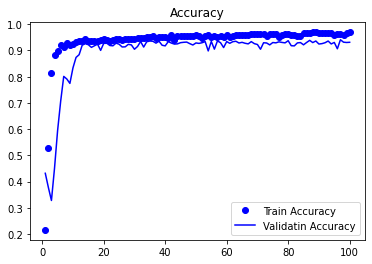

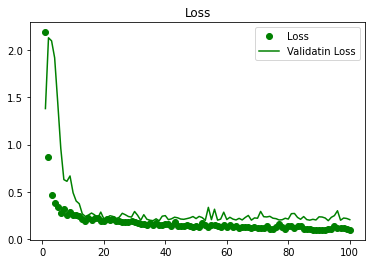

<Figure size 432x288 with 0 Axes>

In [39]:
accuracy = Nested_UNet_history.history["Accuracy"]
val_accuracy = Nested_UNet_history.history["val_Accuracy"]
loss = Nested_UNet_history.history["loss"]
val_loss =  Nested_UNet_history.history["val_loss"]
                 
epochs = range(1, 101)                           
                            
plt.plot(epochs, accuracy, "bo", label="Train Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validatin Accuracy")
plt.title("Accuracy")
plt.legend()
plt.figure()                            
                            
plt.plot(epochs, loss, "go", label="Loss")
plt.plot(epochs, val_loss, "g", label="Validatin Loss")
plt.title("Loss")
plt.legend()
plt.figure()  

In [14]:
Nested_UNet_model_path = os.getenv('HOME')+'/aiffel/AIFEL_Quest/Going_Deeper/Project_05/seg_model_unet++.h5'

Nested_UNet = tf.keras.models.load_model(Nested_UNet_model_path, custom_objects={'combined_loss': combined_loss})

## Deep Lab V3+

In [29]:
DLV3_model_path = os.getenv('HOME')+'/aiffel/AIFEL_Quest/Going_Deeper/Project_05/seg_model_deepLabV3+.h5'

DLV3_plus.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['Accuracy'])

DLV3_plus_history = DLV3_plus.fit(
     DL_train_generator,
     validation_data=DL_test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

Epoch 1/100
22/22 [==============================] - 31s 1s/step - loss: 0.3539 - Accuracy: 0.8482 - val_loss: 0.6423 - val_Accuracy: 0.7691
Epoch 2/100
22/22 [==============================] - 22s 984ms/step - loss: 0.2064 - Accuracy: 0.9140 - val_loss: 0.5908 - val_Accuracy: 0.7691
Epoch 3/100
22/22 [==============================] - 22s 969ms/step - loss: 0.2070 - Accuracy: 0.9172 - val_loss: 0.5791 - val_Accuracy: 0.7691
Epoch 4/100
22/22 [==============================] - 21s 959ms/step - loss: 0.1778 - Accuracy: 0.9287 - val_loss: 0.5577 - val_Accuracy: 0.7691
Epoch 5/100
22/22 [==============================] - 21s 964ms/step - loss: 0.1728 - Accuracy: 0.9302 - val_loss: 0.5440 - val_Accuracy: 0.7691
Epoch 6/100
22/22 [==============================] - 22s 969ms/step - loss: 0.1524 - Accuracy: 0.9413 - val_loss: 0.5401 - val_Accuracy: 0.7691
Epoch 7/100
22/22 [==============================] - 21s 963ms/step - loss: 0.1572 - Accuracy: 0.9385 - val_loss: 0.5425 - val_Accuracy: 0.

22/22 [==============================] - 21s 963ms/step - loss: 0.0786 - Accuracy: 0.9671 - val_loss: 0.1682 - val_Accuracy: 0.9430
Epoch 58/100
22/22 [==============================] - 21s 959ms/step - loss: 0.0831 - Accuracy: 0.9683 - val_loss: 0.2460 - val_Accuracy: 0.9304
Epoch 59/100
22/22 [==============================] - 21s 960ms/step - loss: 0.0727 - Accuracy: 0.9700 - val_loss: 0.2202 - val_Accuracy: 0.9134
Epoch 60/100
22/22 [==============================] - 21s 962ms/step - loss: 0.0709 - Accuracy: 0.9703 - val_loss: 0.1576 - val_Accuracy: 0.9434
Epoch 61/100
22/22 [==============================] - 21s 959ms/step - loss: 0.0647 - Accuracy: 0.9740 - val_loss: 0.2361 - val_Accuracy: 0.9223
Epoch 62/100
22/22 [==============================] - 22s 974ms/step - loss: 0.0685 - Accuracy: 0.9719 - val_loss: 0.1877 - val_Accuracy: 0.9208
Epoch 63/100
22/22 [==============================] - 21s 955ms/step - loss: 0.0732 - Accuracy: 0.9690 - val_loss: 0.2334 - val_Accuracy: 0.925

NameError: name 'own_model' is not defined

In [32]:
DLV3_plus.save(DLV3_model_path)

In [39]:
import os
import json

# Assuming 'DLV3_plus_history' contains the training history
history_path = os.path.join(os.getenv('HOME'), 'aiffel/AIFEL_Quest/Going_Deeper/Project_05/history_DLV3_plus.json')

with open(history_path, 'w') as json_file:
    json.dump(DLV3_plus_history.history, json_file)

<Figure size 432x288 with 0 Axes>

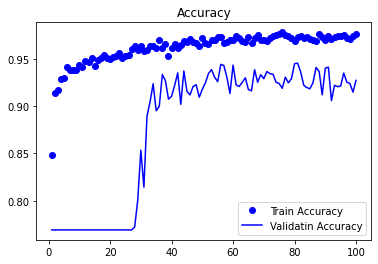

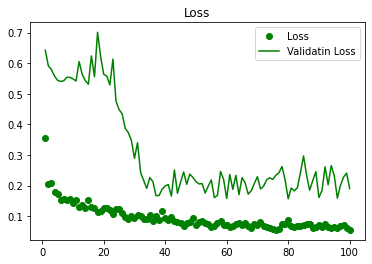

<Figure size 432x288 with 0 Axes>

In [37]:
accuracy = DLV3_plus_history.history["Accuracy"]
val_accuracy = DLV3_plus_history.history["val_Accuracy"]
loss = DLV3_plus_history.history["loss"]
val_loss =  DLV3_plus_history.history["val_loss"]
                 
epochs = range(1, 101)                           
                            
plt.plot(epochs, accuracy, "bo", label="Train Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validatin Accuracy")
plt.title("Accuracy")
plt.legend()
plt.figure()                            
                            
plt.plot(epochs, loss, "go", label="Loss")
plt.plot(epochs, val_loss, "g", label="Validatin Loss")
plt.title("Loss")
plt.legend()
plt.figure()  

In [16]:
DLV3_plus_model_path = os.getenv('HOME')+'/aiffel/AIFEL_Quest/Going_Deeper/Project_05/seg_model_deepLabV3+.h5'

DLV3_plus = tf.keras.models.load_model(DLV3_plus_model_path)

# 3. Check Result

In [44]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    
    processed = preproc(**data)
    
    # Retrieve Predicted Image
    # Input pixel value -> 0~1
    # If Output pixel value > threshold, convert the output value to real scale
    output = model(np.expand_dims(processed["image"]/255, axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255 
    prediction = output/255
    output = Image.fromarray(output)
    
    # Resize output and Convert Format
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    
    backgroud = Image.fromarray(origin_img).convert('RGBA')
    output = Image.blend(backgroud, output, alpha=0.5)
    output.show()
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        
        
        target = (label_processed == 7).astype(np.uint8)*1   

        return output, prediction, target
    
    else:
        return output, prediction, _

In [38]:
def calculate_iou_score(target, prediction):
    add = target + prediction
    
    count_1 = 0
    count_2 = 0
    for row in add:
        for column in row:
            if column == 1:
                count_1 += 1
            elif column == 2:
                count_2 += 1
    
    intersection = count_2
    union = count_2 + count_1
    iou_score = intersection / union * 100
    return iou_score

## UNet model Inference Image 

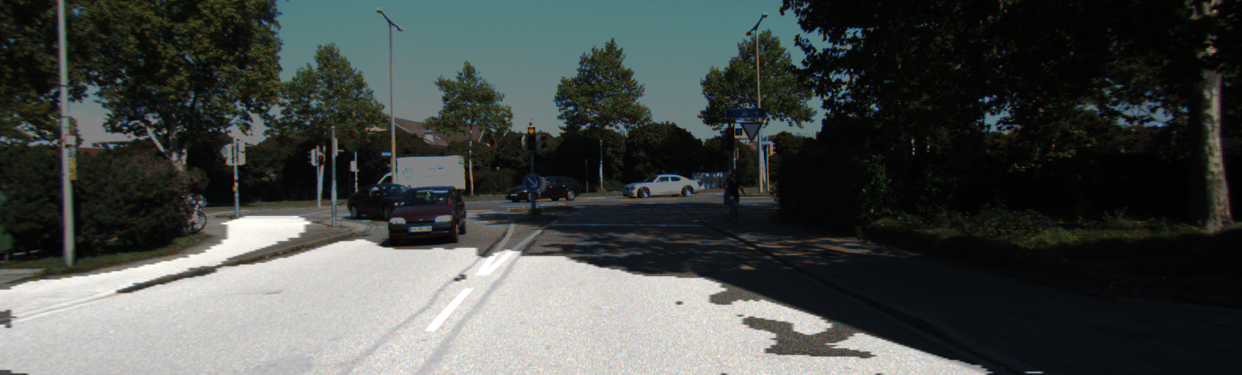

In [62]:
i = 7
output, prediction, target = get_output(
     own_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

In [63]:
calculate_iou_score(target, prediction)

IoU : 68.222621


68.2226211849192

## UNet++ model Inference Image 

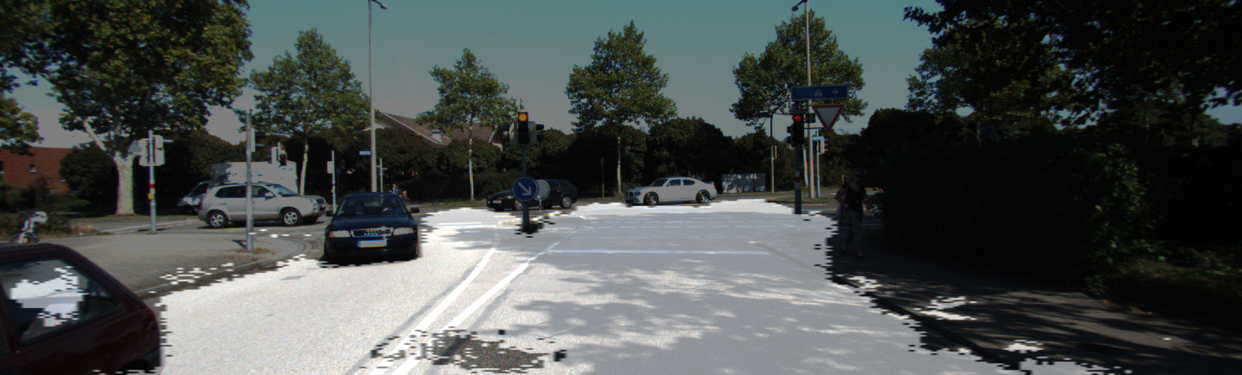

In [45]:
i = 8
output, prediction, target = get_output(
     Nested_UNet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

In [65]:
calculate_iou_score(target, prediction)

IoU : 90.506234


90.50623403935707

## DeepLabV3+ model Inference Image 

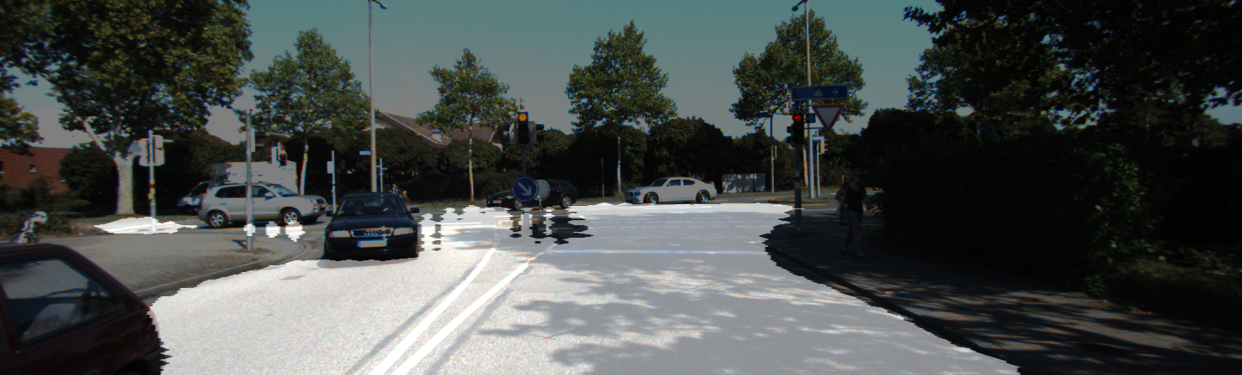

In [46]:
i = 8
output, prediction, target = get_output(
     DLV3_plus, 
     DLtest_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

In [23]:
calculate_iou_score(target, prediction)

IoU : 94.289539


94.28953910881623

## IOU compare

In [47]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    
    processed = preproc(**data)
    
    # Retrieve Predicted Image
    # Input pixel value -> 0~1
    # If Output pixel value > threshold, convert the output value to real scale
    output = model(np.expand_dims(processed["image"]/255, axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255 
    prediction = output/255
    output = Image.fromarray(output)
    
    # Resize output and Convert Format
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    
    backgroud = Image.fromarray(origin_img).convert('RGBA')
    output = Image.blend(backgroud, output, alpha=0.5)
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        
        
        target = (label_processed == 7).astype(np.uint8)*1   

        return output, prediction, target
    
    else:
        return output, prediction, _

In [40]:
model_list = []
model_list.append(UNet)
model_list.append(Nested_UNet)
model_list.append(DLV3_plus)
model_name_list = ["UNet", "UNet++", "DeepLabV3+"]

In [41]:
for i in range(20):
    print(f"======{i} 번째 사진 IOU 값======")
    for j in range(3):
        if j == 2:
            output, prediction, target = get_output(
                 model_list[j], 
                 DLtest_preproc,
                 image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
                 output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
                 label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
            )
        else: 
            output, prediction, target = get_output(
                 model_list[j], 
                 test_preproc,
                 image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
                 output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
                 label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
            )
        IOU = calculate_iou_score(target, prediction)
        print(f"{model_name_list[j]} IOU Score: {IOU}")

======0 번째 사진 IOU 값======
UNet IOU Score: 16.91919191919192
UNet++ IOU Score: 93.52323360916614
DeepLabV3+ IOU Score: 96.68419083623762
======1 번째 사진 IOU 값======
UNet IOU Score: 41.96408941004031
UNet++ IOU Score: 92.40325252221051
DeepLabV3+ IOU Score: 95.80840642001122
======2 번째 사진 IOU 값======
UNet IOU Score: 58.40873634945398
UNet++ IOU Score: 80.56941590842384
DeepLabV3+ IOU Score: 91.66976648067782
======3 번째 사진 IOU 값======
UNet IOU Score: 57.12116368286445
UNet++ IOU Score: 77.49484443647448
DeepLabV3+ IOU Score: 82.44607516121859
======4 번째 사진 IOU 값======
UNet IOU Score: 56.029585164540684
UNet++ IOU Score: 82.5925925925926
DeepLabV3+ IOU Score: 90.95139419056967
======5 번째 사진 IOU 값======
UNet IOU Score: 64.70318061775176
UNet++ IOU Score: 82.94142201196605
DeepLabV3+ IOU Score: 93.6662754461937
======6 번째 사진 IOU 값======
UNet IOU Score: 9.676714722586283
UNet++ IOU Score: 86.52950310559007
DeepLabV3+ IOU Score: 89.68652667537425
======7 번째 사진 IOU 값======
UNet IOU Score: 68.2226

# Wrap up
## IOU 성능비교  
   UNet < UNet++ < DeepLabV3+    
     
## UNet 과 UNet history 그래프 비교  
 1. UNet history 그래프 추이를 보면 Validation accuray들이 spark부분이 관측된다.   
 2. Upsampling 및 Skip Connection이 feature maps들을 더 잘 반영해주어 object detection에 유리한 feature map을 만들어준다고 생각할 수 있다.  
 
## Deep Lab V3+ -> 가장 좋은 성능
 1. Feature map을 크게 가져가는 것 + sparse convolution 이 object detection에 도움을 준다.      
 2. 그림 8번을 보면 더 정교한 object detection을 하는 것을 볼 수 있다.  
 3. 파라미터수와 연산량을 비슷하게 가져가면서 더 좋은 성능을 낼 수 있다.  
 4. (개선점)  Validation accuray들이 spark부분이 관측된다 -> Unet++ 처럼 디코더 과정을 좀 더 정교하게 구현하면 개선될 여지가 많고 성능을 높일 수 있다.  